In [1]:
import math
import copy
import numpy as np 
import statistics
import matplotlib.pyplot as plt

In [2]:
class Node:
    def __init__(self, label):
        self.label = label
        self.children = dict()

    def isLeaf(self):
        return len(self.children) == 0

In [3]:
def get_total(data):
    total = 0.0

    for row in data:
        total += row['weights']
    
    return total

In [4]:
def set_subset(data, attribute, val):
    sub_data = []

    for row in data:
        if row[attribute] == val:
            sub_data.append(row)

    return sub_data

In [5]:
def set_label(row, dt):
    new_dt = dt

    while not new_dt.isLeaf():
        curr_attr = new_dt.label
        attr_val = row[curr_attr]
        new_dt = new_dt.children[attr_val]

    return new_dt.label

In [6]:
def entropy(data):
    
    if len(data) == 0:
        return 0
    
    counts = dict()

    for row in data:
        label = row['y']
        if label not in counts:
            counts[label] = 0.0
            
        counts[label] += row['weights']

    entropy = 0.0
    total = get_total(data)
    for (label, count) in counts.items():
        p = count / total
        entropy += -p * math.log2(p)

    return entropy

def gini_index(data):
    if len(data) == 0:
        return 0
    
    counts = dict()

    for row in data:
        label = row['y']
        if label not in counts:
            counts[label] = 0.0
        counts[label] += row['weights']

    sq_sum = 0.0
    total =  get_total(data)
    for (label, count) in counts.items():
        p = count / total
        sq_sum +=p **2

    return 1-sq_sum

def ME(data):
    if len(data) == 0:
        return 0
    
    counts = dict()

    for row in data:
        label = row['y']
        if label not in counts:
            counts[label] = 0.0
        counts[label] += row['weights']

    max_p = 0.0
    total = get_total(data)
    for (label, count) in counts.items():
        p = count / total
        max_p = max(max_p, p)

    return 1-max_p

In [7]:
def info_gain(data,gain_type,attribute, vals):
    
    measure = None
    gain = 0.0
    if gain_type == 0:
        measure=entropy(data)
           
    elif gain_type == 1:
         measure=gini_index(data)
        
    elif gain_type == 2:
         measure=ME(data)
            
    for val in vals:
        sub_set = set_subset(data, attribute, val)
        total=get_total(data)
        sub_total=get_total(sub_set)
        p = sub_total /total
        gain += p * measure
        gain_x= measure-gain
        
    return gain_x

In [8]:
def select_feature(data,gain_type, attributes):
    gain_x= dict()

    for ln, lv in attributes.items():
        gain = info_gain(data,gain_type, ln, lv)
        gain_x[ln] = gain
        max_attr=max(gain_x.keys(), key=lambda key: gain_x[key])

    return max_attr

In [9]:
def majority_label(data):
    
    counts = dict()
    for row in data:
        label = row['y']
        
        if label not in counts:
            counts[label] = 0.0
            
        counts[label] += row['weights']
        
    common_label=max(counts.keys(), key=lambda key: counts[key])

    return common_label

In [10]:
def ID3(data,gain_type, attributes, labels, max_depth,depth):
    
    if (len(attributes) == 0) or depth==max_depth:
        label = majority_label(data)
        
        return Node(label)
    
    if (len(labels) == 1):
        label = labels.pop()
        
        return Node(label)

    #recursion
    max_attr = select_feature(data,gain_type,attributes)
    root = Node(max_attr)
    

    # split into subsets
    for v in attributes[max_attr]:
        sub_set = set_subset(data, max_attr, v)

        if len(sub_set) == 0:
            label = majority_label(data)
            root.children[v] = Node(label)
            
        else:
            
            sub_attributes = copy.deepcopy(attributes)
            sub_attributes.pop(max_attr)

            # update subset labels set
            sub_labels = set()
            for row in sub_set:
                sub_label = row['y']
                if  sub_labels not in sub_labels:
                    sub_labels.add(sub_label)

            # recursion
            root.children[v] = ID3(sub_set, gain_type,sub_attributes, sub_labels, max_depth, depth+1)

    return root

In [11]:
def cls(data, gain_type,attributes, labels,max_depth,depth,T):
    
    DT=[]
    for t in range(0, T):
        random_data=[random.choice(data) for i in range(len(data))]
        dt= ID3(data, gain_type,attributes, labels, max_depth,depth)
        DT.append(dt)
    
    return DT

In [26]:
def prediction(data, DT):
    
    h_rate = 0

    for row in data:
        pred = 0.0
        
        for dt in DT:
            label = set_label(row,dt)
            label = 1 if label == 'yes' else -1
            pred += label 

        if row['y'] == 'yes' and pred > 0:
            h_rate += 1
        if row['y'] == 'no' and pred < 0:
            h_rate += 1
    
    return h_rate/len(data)

In [13]:
attributes = {'age': [0, 1], 
        'job': ['admin.', 'unknown', 'unemployed', 'management', 'housemaid', 'entrepreneur', 'student', 'blue-collar', 'self-employed', 'retired', 'technician', 'services'], 
        'marital': ['married','divorced','single'], 
        'education': ['unknown', 'secondary', 'primary', 'tertiary'],
        'default': ['yes', 'no'],
        'balance': [0, 1], 
        'housing': ['yes', 'no'],
        'loan': ['yes', 'no'],
        'contact': ['unknown', 'telephone', 'cellular'],
        'day': [0, 1],  
        'month': ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec'],
        'duration': [0, 1],
        'campaign': [0, 1], 
        'pdays': [0, 1], 
        'previous': [0, 1], 
        'poutcome': ['unknown', 'other', 'failure', 'success']}

In [14]:
if __name__ == '__main__':
    
    columns = ['age', 'job', 'marital', 'education', 'default', 'balance', 'housing', 'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'y']
    labels = {'yes', 'no'}
    numeric_attrs = ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']

In [15]:
# read training data
train_data=[]
with open('train.csv', 'r') as f:
    for line in f:
        example = dict()
        terms = line.strip().split(',')
        for i in range(len(terms)):
            attrName = columns[i]
            example[attrName] = terms[i]
        
        train_data.append(example)

In [16]:
# read test data
test_data=[]
with open('test.csv', 'r') as f:
    for line in f:
        example = dict()
        terms = line.strip().split(',')
        for i in range(len(terms)):
            attrName = columns[i]
            example[attrName] = terms[i]
        
        test_data.append(example)

In [17]:
#convert numeric variable to binary variable
medians = {'age': 0.0,'balance': 0.0,'day': 0.0,'duration': 0.0,'campaign': 0.0,'pdays': 0.0,'previous': 0.0}
 
for key in medians.keys():
    vals = []
    for row in train_data:
        vals.append(float(row[key]))
    medians[key] = statistics.median(vals)


In [18]:
#if >median, 1 else 0
for key, value in medians.items():
    for row in train_data:
        val = float(row[key])
        row[key] = 1 if val > value else 0

    for row in test_data:
        val = float(row[key])
        row[key] = 1 if val > value else 0

In [19]:
#initialize the weight
train_size=len(train_data)
test_size=len(test_data)
for row in train_data:
    row['weights'] = 1/train_size

for row in test_data:
    row['weights'] = 1/test_size
    

In [23]:
import random

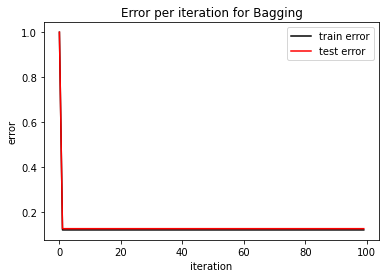

In [29]:
train_T=[]
test_T=[]
for T in range(100):
    trees = cls(train_data,0, attributes, labels, 1,0,T)
    h_train = prediction(train_data, trees )
    h_test = prediction(test_data, trees)
    h_x=1-h_train
    h_y=1-h_test
    train_T.append(h_x)
    test_T.append(h_y)
x1=[x for x in range(100) ]
y1=train_T
y2=test_T
fig, ax = plt.subplots(figsize = (6,4))
ax.plot(x1,y1, label='train error', c='black')
ax.plot(x1,y2, label='test error', c='red')
ax.legend()
ax.set_title("Error per iteration for Bagging")
ax.set_xlabel('iteration')
ax.set_ylabel('error')

plt.show()

In [32]:
def select_sample(data, data_size):
    
    data_copy = copy.deepcopy(data)
    
    samples = []
    for i in range(data_size):
        idx = random.randint(0, len(data_copy)-1)
        samples.append(data_copy[idx])
        del data_copy[idx]
    return samples

In [33]:
pred = []
#REPEAT for 100 times
for i in range(100):
    #Sample 1000 examples uniformly without replacement
    samples=select_sample(train_data,data_size=1000)
    #learn 500 trees
    DT = cls(train_data,0, attributes, labels, 1,0,500)
    pred.append(DT)

In [34]:
#single tree bias and variance
single_bias = 0.0
single_var = 0.0
sum_single_bias=0.0
sum_single_var=0.0
for row in test_data:
    avg = 0
    predictions = []
    for DT in pred:
        dt= DT[0]
        label = set_label(row, dt)
        label = 1 if label == 'yes' else -1
        avg += label
        predictions.append(label)
    avg /= len(predictions)
    y = 1 if row['y'] == 'yes' else -1
    single_bias = pow(y - avg, 2)
    single_var = np.var(predictions)

    sum_single_bias += single_bias
    sum_single_var += single_var
    
avg_single_bias = sum_single_bias/len(test_data)
#print(avg_single_bias)
avg_single_var = sum_single_var/len(test_data)
#print(avg_single_var)

In [39]:
#bagging tree bias and variance
bag_bias = 0.0
bag_var = 0.0
sum_bag_bias=0.0
sum_bag_var=0.0
for row in test_data:
    avg = 0
    predictions = []
    for DT in pred:
        Label=0
        for dt in DT:
            label = set_label(row, dt)   
            label = 1 if label == 'yes' else -1
            Label/=len(DT)
            Label+=label
            avg += Label
        
        predictions.append(Label)
    avg /= len(predictions)
    
    y = 1 if row['y'] == 'yes' else -1
    bag_bias = pow(y - avg, 2)
    bag_var = np.var(predictions)

    sum_bag_bias += bag_bias
    sum_bag_var += bag_var

avg_bag_bias = sum_bag_bias/len(test_data)
#print(avg_bag_bias)
avg_bag_var = sum_bag_var/len(test_data)
#print(avg_bag_var)